In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from CHAMP.DataLoader import LoadData, LoadFaceDB
from CHAMP.Monitor import DisplayDico, DisplayConvergenceCHAMP, DisplayConvergenceClassif
from CHAMP.CHAMP_Layer import ConvMP
from CHAMP.DataTools import GenerateGabor, Rebuilt, ContrastNormalized, ChangeBatchSize
import matplotlib.pyplot as plt
from CHAMP.LowLevel import conv
from CHAMP.Classif_Layer import Classif_Layer
import os
home = os.getenv('HOME')
from CHAMP.DataTools import SaveNetwork, LoadNetwork

In [ ]:
l0 = 100
nb_dico = 8
dico_size = (5,5)
image_size = (32,32)
OutputL1_size =tuple(image_size[i]-dico_size[i]+1 for i in range(len(dico_size)))
saving_path = 'Records/'

# On CIFAR Color DataBase

## Load the DataBase

In [3]:
path = "../../../Science/These/Rapport d'avancement/database/CIFARtorch/"
#path = home + "/science/VB_These/Rapport d'avancement/database/Face_DataBase/"
training_set,testing_set = LoadData('CIFAR',data_path=path,avg_size=(5,5),decorrelate=False,Grayscale=False)

In [30]:
import torch
from torch.autograd import Variable
from torch.nn.functional import conv2d
import pickle
import cv2
import math
from CHAMP.LowLevel import conv, Normalize, padTensor
def ContrastNormalized2(data,avg_size=(5,5)):
    assert avg_size[1]%2 == 1, 'deccorlation filters size should be odd'
    img_size = data[0].size()
    output_tensor = torch.FloatTensor(img_size)
    to_conv = (torch.ones(avg_size)*1/(avg_size[-1]*avg_size[-1])).view(1,avg_size[0],avg_size[1],avg_size[2])
    print(to_conv.size())
    for idx_batch, each_batch in enumerate(data[0]):
        padded_tensor = padTensor(each_batch,avg_size[1]//2,mode='reflect')
        convol = conv(padded_tensor,to_conv)
        output_tensor[idx_batch,:,:,:,:] = each_batch - convol
    return output_tensor, data[1]

In [31]:
training_set_norm = ContrastNormalized2(training_set,avg_size=(3,5,5))

torch.Size([1, 3, 5, 5])


In [6]:
test = training_set[0].permute(0,1,3,4,2)
print(training_set[0].size(),test.size())

torch.Size([1, 50000, 3, 32, 32]) torch.Size([1, 50000, 32, 32, 3])


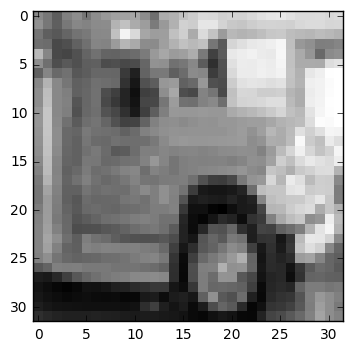

In [24]:
#plt.imshow(test[0,10,:,:,:].numpy())
plt.imshow(test[0,10,:,:,0].numpy(),cmap=('gray'))

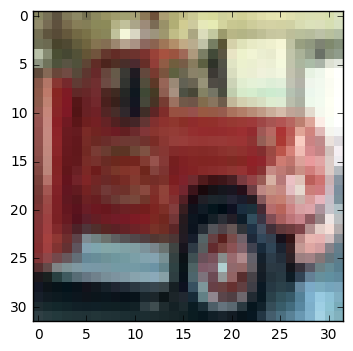

In [21]:
plt.imshow(test[0,10,:,:,:].numpy())

In [9]:
test2 = training_set_norm[0].permute(0,1,3,4,2)

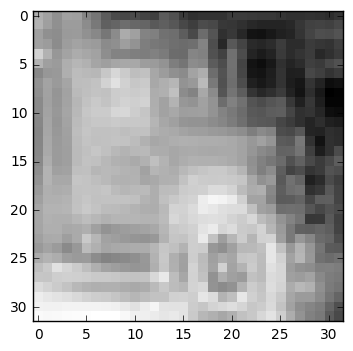

In [29]:
plt.imshow(test2[0,10,:,:,2].numpy(),cmap='gray')

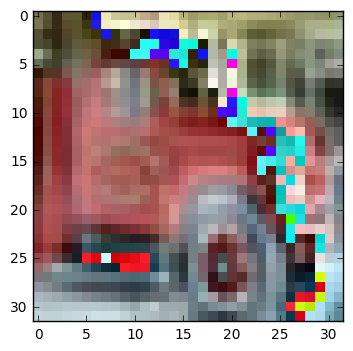

In [10]:
plt.imshow((test2[0,10,:,:,:].numpy()))

In [ ]:
path = "../../../Science/These/Rapport d'avancement/database/CIFARtorch/"
#path = home + "/science/VB_These/Rapport d'avancement/database/Face_DataBase/"
training_set,testing_set = LoadData('CIFAR',data_path=path,avg_size=(5,5),decorrelate=True)

In [ ]:
print(testing_set[0].size())

In [ ]:
plot = plt.imshow(testing_set[0][0,0,0,:,:].numpy(),cmap='gray')

## Generate Filters

In [ ]:
DicoGabor = GenerateGabor(nb_dico=nb_dico,dico_size=dico_size,sigma=1.5,lambd=5,gamma=0.5,psi=0)
DisplayDico(DicoGabor)

## Coding

In [ ]:
code_training = ConvMP(image_input=training_set[0][0,:,:,:,:], dictionary=DicoGabor, l0_sparseness=l0,
                modulation=None, verbose=0, train=True, doSym='pos', mask=None,\
                MaskMod='Residual')

In [ ]:
reconstructed_image = Rebuilt(training_set[0][0,:,:,:,:],code_training,DicoGabor)

In [ ]:
plt.imshow(reconstructed_image[0,0,:,:].numpy(),cmap='gray')

In [ ]:
residual=training_set[0][0,:,:,:,:]-reconstructed_image

In [ ]:
plt.imshow(residual[0,0,:,:].numpy(),cmap='gray')

In [ ]:
code_testing = ConvMP(image_input=testing_set[0][0,:,:,:,:], dictionary=DicoGabor, l0_sparseness=l0,
                modulation=None, verbose=0, train=True, doSym='pos', mask=None,\
                MaskMod='Residual')

## Classifying Row Data

In [ ]:
SaveExp = False

In [ ]:
batch_training_set = ChangeBatchSize(training_set,batch_size=2000)

In [ ]:
from CHAMP.Classif_Layer import Classif_Layer
if SaveExp == True:
    Classifier_Raw = Classif_Layer(nb_dico=1,size_image=image_size,nb_categories=10, verbose=0)
    Classifier_Raw = Classifier_Raw.train_classif(batch_training_set,nb_epoch=20000,\
                                                  data_test_loader=testing_set,lr=0.003)
    SaveNetwork(Classifier_Raw, saving_path+'CIFAR_ClassifRaw.pkl')
else : 
    Classifier_Raw = LoadNetwork(saving_path+'CIFAR_ClassifRaw.pkl')

In [ ]:
DisplayConvergenceClassif(Classifier_Raw, to_display=['error','accu'])

## Classifying Output of One CHAMP Layer

In [ ]:
SaveExp = True

In [ ]:
output_Layer1_training = (code_training.to_dense().unsqueeze(0),training_set[1])
output_Layer1_testing = (code_testing.to_dense().unsqueeze(0),testing_set[1])

In [ ]:
training_L1_CHAMP = ChangeBatchSize(output_Layer1_training,5000)


In [ ]:
from CHAMP.Classif_Layer import Classif_Layer
if SaveExp == True:
    Classifier_CHAMP = Classif_Layer(nb_dico=8,size_image=OutputL1_size,verbose=0,nb_categories=10)
    Classifier_CHAMP = Classifier_CHAMP.train_classif(training_L1_CHAMP,nb_epoch=20000,\
                                   data_test_loader=output_Layer1_testing ,lr=0.003)
    SaveNetwork(Classifier_CHAMP, saving_path+'CIFAR_ClassifCHAMP.pkl')
else : 
    Classifier_CHAMP = LoadNetwork(saving_path+'CIFAR_ClassifCHAMP.pkl')

In [ ]:
DisplayConvergenceClassif(Classifier_CHAMP, to_display=['error','accu'])

In [ ]:
stop_here

## Classyfing output of Convolutional Layer

In [ ]:
SaveExp = False

In [ ]:
Output_L1Conv_training = conv(training_set[0][0,:,:,:,:], DicoGabor)
Output_L1Conv_training = (Output_L1Conv_training.unsqueeze(0),training_set[1])
Output_L1Conv_testing = conv(testing_set[0][0,:,:,:,:], DicoGabor)
Output_L1Conv_testing = (Output_L1Conv_testing.unsqueeze(0),testing_set[1])
Output_L1Conv_training  = ChangeBatchSize(Output_L1Conv_training,2000)

In [ ]:
from CHAMP.Classif_Layer import Classif_Layer
if SaveExp == True:
    Classifier_CONV = Classif_Layer(nb_dico=8,size_image=OutputL1_size,verbose=0,nb_categories=10)
    Classifier_CONV = Classifier_CONV.train_classif(Output_L1Conv_training,nb_epoch=20000,\
                                                    data_test_loader=Output_L1Conv_testing,lr=0.003)
    SaveNetwork(Classifier_CONV, saving_path+'CIFAR_ClassifCONV.pkl')
else : 
    Classifier_CONV = LoadNetwork(saving_path+'CIFAR_ClassifCONV.pkl'
    

In [ ]:
DisplayConvergenceClassif(Classifier_CONV, to_display=['error','accu'])

# On CIFAR DataBase in Color

In [ ]:
print(testing_set[0].size())

In [ ]:
training_set = ContrastNormalized2(training_set,avg_size=(3,5,5))

In [ ]:
test = training_set[0].permute(0,1,3,4,2)
print(test.size())